# Tweet Engagement Quality Classifier

### 1. Project description
For this project I'll be building a **Tweet Engagement Quality Classifier** that predicts whether a tweet will have `high`, `medium`, or `low engagement` based solely on its text content. The model will analyze linguistic patterns, sentiment, and content structure to classify tweets. 

This practical tool can help content creators optimize their tweets before posting.

### 2. Dataset description
For this project I'll be using [Kaggle Twitter-Dataset](https://www.kaggle.com/datasets/goyaladi/twitter-dataset) this is a curated collection of tweets carefully gathered from the vast Twitter ecosystem. This comprehensive dataset offers a valuable resource for researchers, data scientists, and enthusiasts interested in exploring the dynamics of social media communication. Spanning diverse topics, industries, and regions, our dataset provides an in-depth understanding of trends, sentiments, and user behavior within the Twitterverse. Analyze engagement metrics, track the evolution of hashtags, uncover influential users, and gain insights into the ever-changing landscape of online conversations. With our Twitter dataset, you can unlock the power of social media data to fuel research, drive innovation, and gain a deeper understanding of the world through the lens of Twitter.

**twitter_dataset.csv**

Our Twitter dataset in CSV format contains essential information about tweets from the Twitter platform. Each row represents a single tweet, and the dataset includes fields such as tweet ID, username, tweet text, retweet count, like count, and timestamp.
This concise dataset provides a snapshot of the Twitter ecosystem, enabling researchers, analysts, and enthusiasts to analyze user engagement, track trends, and gain insights into social media behavior. The CSV format facilitates easy data manipulation and integration with various analytical tools and programming languages.
Unleash the power of this Twitter dataset to unravel patterns, understand user dynamics, and extract meaningful information from the vast realm of Twitter.

| Column | Description |
|:--------|:------------|
| Tweet_ID |Represents a unique identifier assigned to each individual tweet.|
| Username |Contains the Twitter handles or usernames of the users who posted the tweet.|
| Text |Contains the actual text content of the tweets.|
| Retweets |Represents the number of times a particular tweet has been retweeted by another user.|
| Likes |Captures the number of likes or favorites received by a particular user.|
| Timestamp |Represents the date and time when a tweet was posted on Twitter.|

### 3. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures.

In [1]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import re
import seaborn as sns
import tensorflow as tf

from collections import Counter
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

2025-12-08 11:52:50.226229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# General plot styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('data/twitter_dataset.csv')
print(f"twitter_dataset.csv shape: {df.shape}")
df.head()

twitter_dataset.csv shape: (10000, 6)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [4]:
# Info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   10000 non-null  int64 
 1   Username   10000 non-null  object
 2   Text       10000 non-null  object
 3   Retweets   10000 non-null  int64 
 4   Likes      10000 non-null  int64 
 5   Timestamp  10000 non-null  object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB
None


In [5]:
# Nulls
print(df.isnull().sum())

Tweet_ID     0
Username     0
Text         0
Retweets     0
Likes        0
Timestamp    0
dtype: int64


In [6]:
# Stats
print(df.describe())

          Tweet_ID      Retweets         Likes
count  10000.00000  10000.000000  10000.000000
mean    5000.50000     49.721200     49.929300
std     2886.89568     28.948856     28.877193
min        1.00000      0.000000      0.000000
25%     2500.75000     25.000000     25.000000
50%     5000.50000     49.000000     50.000000
75%     7500.25000     75.000000     75.000000
max    10000.00000    100.000000    100.000000


In [7]:
# Duplicates
duplicates = df.duplicated().sum()
print(f"Duplicates: {duplicates}")

Duplicates: 0


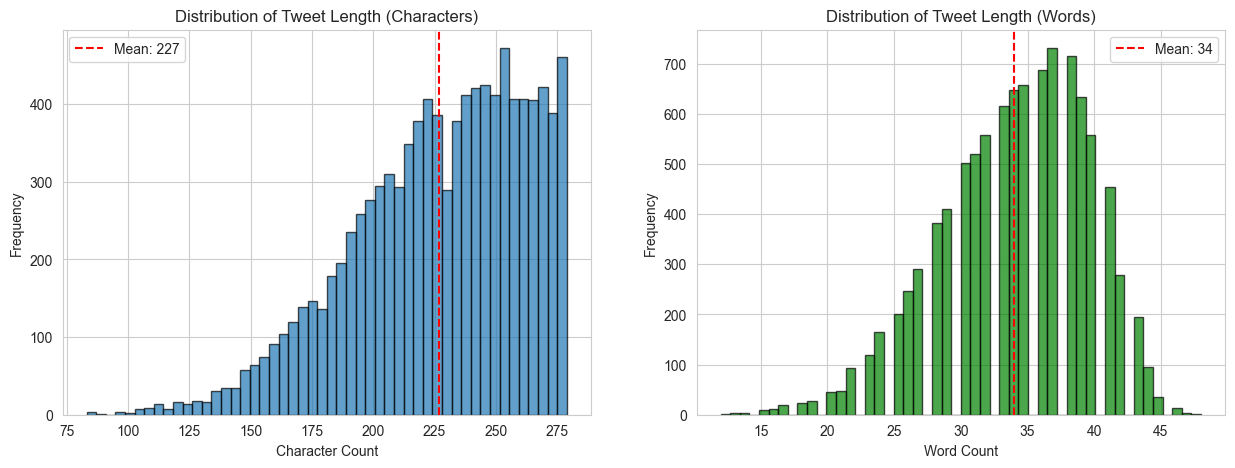

In [8]:
# Text length analysis
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Tweet Length (Characters)')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
axes[0].legend()

axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Tweet Length (Words)')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
axes[1].legend()

plt.show()

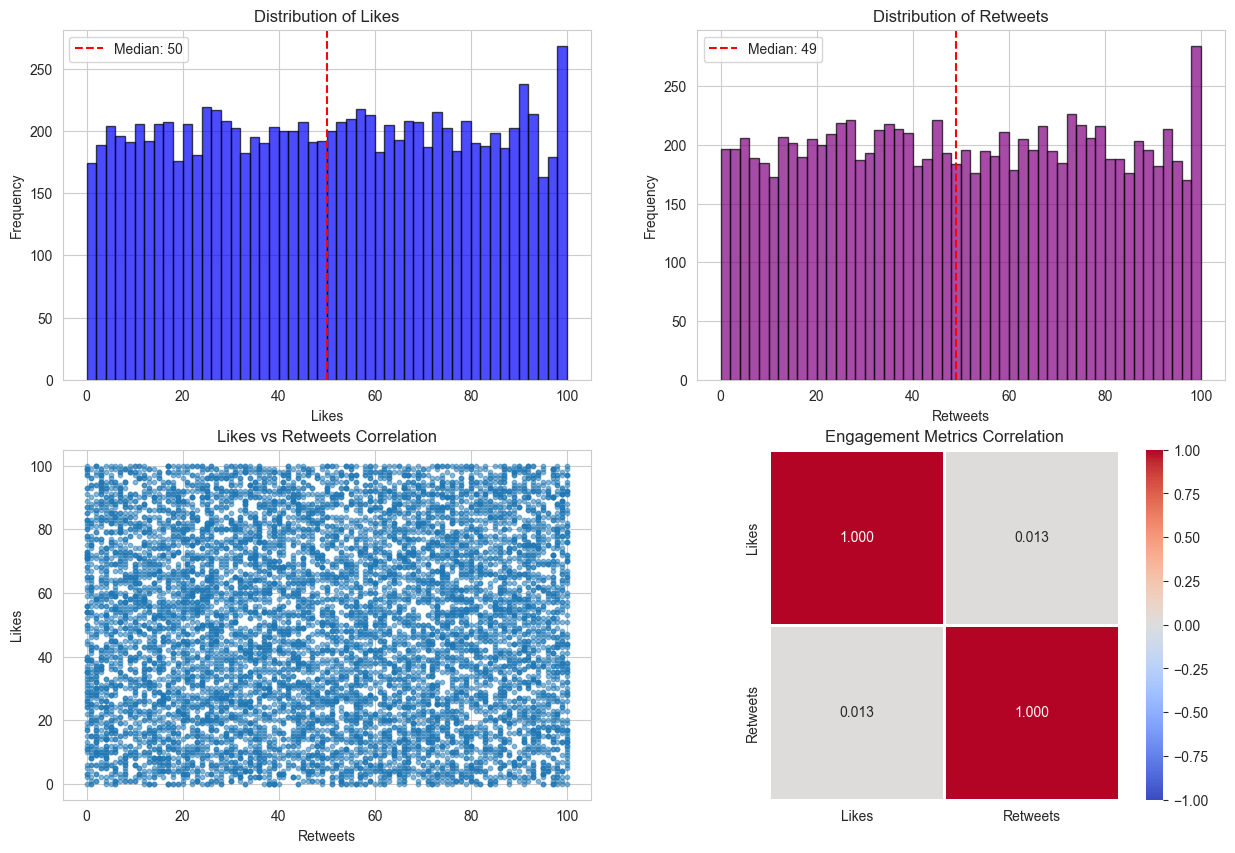

In [9]:
# Engagement stats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Likes distribution
axes[0, 0].hist(df['Likes'], bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Likes')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Likes')
axes[0, 0].axvline(df['Likes'].median(), color='red', linestyle='--', label=f'Median: {df["Likes"].median():.0f}')
axes[0, 0].legend()

# Retweets distribution
axes[0, 1].hist(df['Retweets'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].set_xlabel('Retweets')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Retweets')
axes[0, 1].axvline(df['Retweets'].median(), color='red', linestyle='--', label=f'Median: {df["Retweets"].median():.0f}')
axes[0, 1].legend()

# Likes vs Retweets scatter
axes[1, 0].scatter(df['Retweets'], df['Likes'], alpha=0.5, s=10)
axes[1, 0].set_xlabel('Retweets')
axes[1, 0].set_ylabel('Likes')
axes[1, 0].set_title('Likes vs Retweets Correlation')

# Correlation heatmap
correlation = df[['Likes', 'Retweets']].corr()
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1, 1], 
            vmin=-1, vmax=1, center=0, square=True, linewidths=1)
axes[1, 1].set_title('Engagement Metrics Correlation')

plt.show()

In [10]:
# Temporal stats
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['date'] = df['Timestamp'].dt.date
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.day_name()
df['month'] = df['Timestamp'].dt.month_name()

# Calculate tweet age in days from the most recent tweet
max_date = df['Timestamp'].max()
df['tweet_age_days'] = (max_date - df['Timestamp']).dt.days
print(f"Dataset date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Total days in dataset: {(df['Timestamp'].max() - df['Timestamp'].min()).days} days\n")
print(f"Tweet age stats in days:")
print(df['tweet_age_days'].describe())

Dataset date range: 2023-01-01 00:01:15 to 2023-05-15 12:32:09
Total days in dataset: 134 days

Tweet age stats in days:
count    10000.000000
mean        67.193200
std         38.880093
min          0.000000
25%         34.000000
50%         67.000000
75%        101.000000
max        134.000000
Name: tweet_age_days, dtype: float64


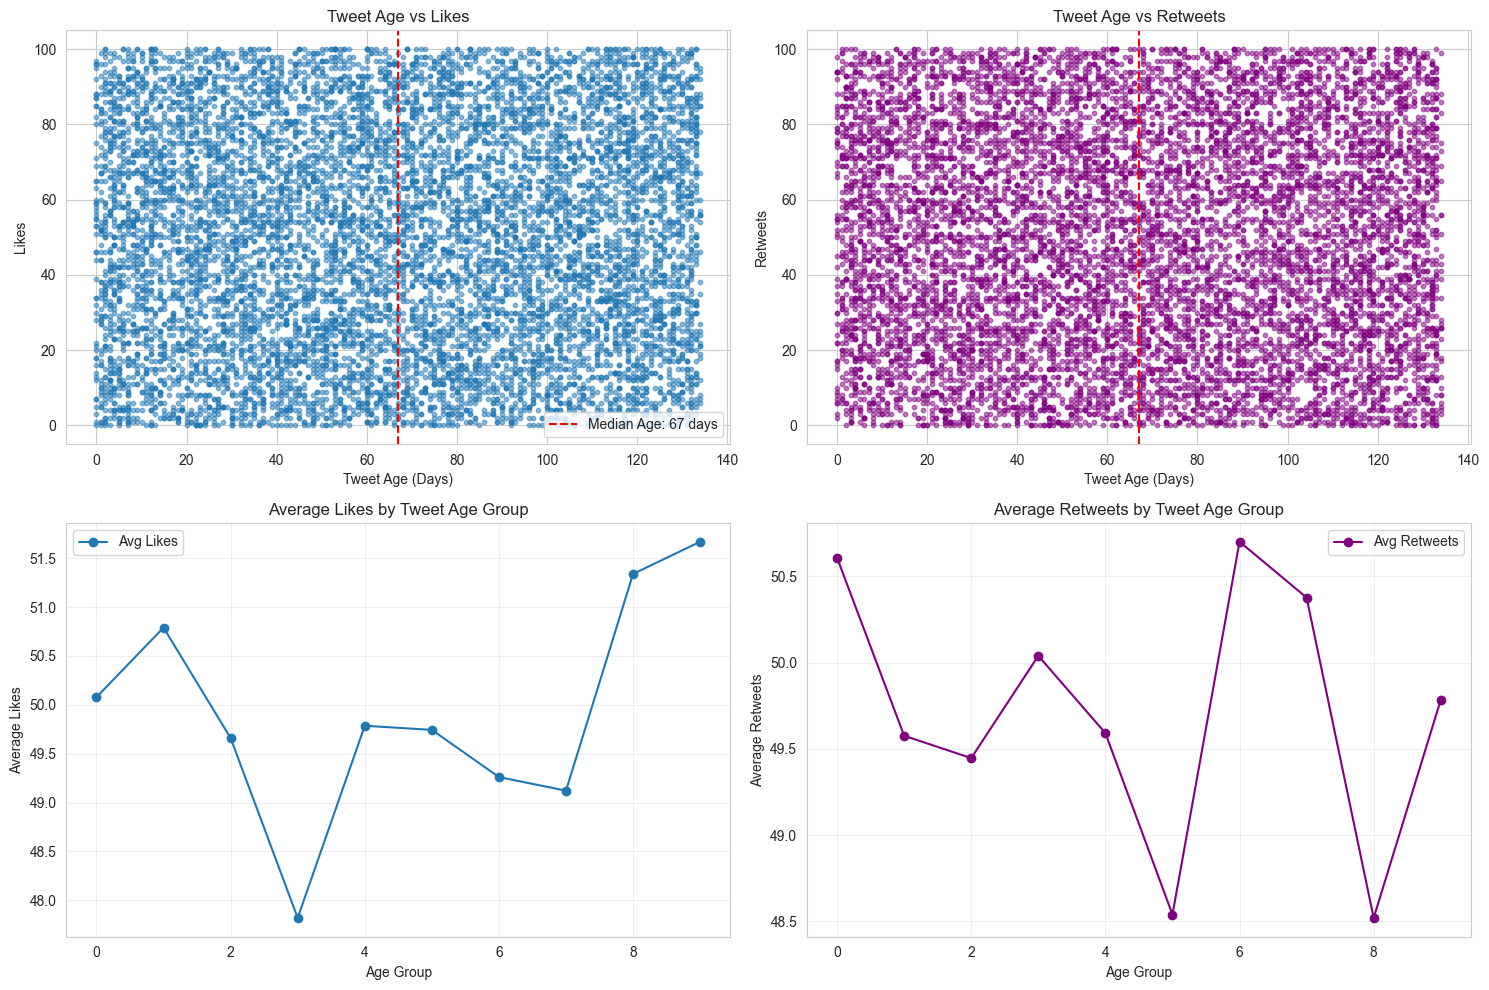

In [11]:
# Tweet days vs Engagement
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tweet age vs Likes scatter
axes[0, 0].scatter(df['tweet_age_days'], df['Likes'], alpha=0.5, s=10)
axes[0, 0].set_xlabel('Tweet Age (Days)')
axes[0, 0].set_ylabel('Likes')
axes[0, 0].set_title('Tweet Age vs Likes')
axes[0, 0].axvline(df['tweet_age_days'].median(), color='red', linestyle='--', 
                   label=f'Median Age: {df["tweet_age_days"].median():.0f} days')
axes[0, 0].legend()

# Tweet age vs Retweets scatter
axes[0, 1].scatter(df['tweet_age_days'], df['Retweets'], alpha=0.5, s=10, color='purple')
axes[0, 1].set_xlabel('Tweet Age (Days)')
axes[0, 1].set_ylabel('Retweets')
axes[0, 1].set_title('Tweet Age vs Retweets')
axes[0, 1].axvline(df['tweet_age_days'].median(), color='red', linestyle='--')

# Correlation over time bins
df['age_bin'] = pd.cut(df['tweet_age_days'], bins=10)
age_engagement = df.groupby('age_bin', observed=True)[['Likes', 'Retweets']].mean()

axes[1, 0].plot(range(len(age_engagement)), age_engagement['Likes'], marker='o', label='Avg Likes')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Average Likes')
axes[1, 0].set_title('Average Likes by Tweet Age Group')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(len(age_engagement)), age_engagement['Retweets'], marker='o', 
               color='purple', label='Avg Retweets')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Average Retweets')
axes[1, 1].set_title('Average Retweets by Tweet Age Group')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Correlations
likes_age_corr = df['Likes'].corr(df['tweet_age_days'])
retweets_age_corr = df['Retweets'].corr(df['tweet_age_days'])

print(f"Correlation between tweet age and Likes: {likes_age_corr:.3f}")
print(f"Correlation between tweet age and Retweets: {retweets_age_corr:.3f}")

Correlation between tweet age and Likes: 0.013
Correlation between tweet age and Retweets: -0.005


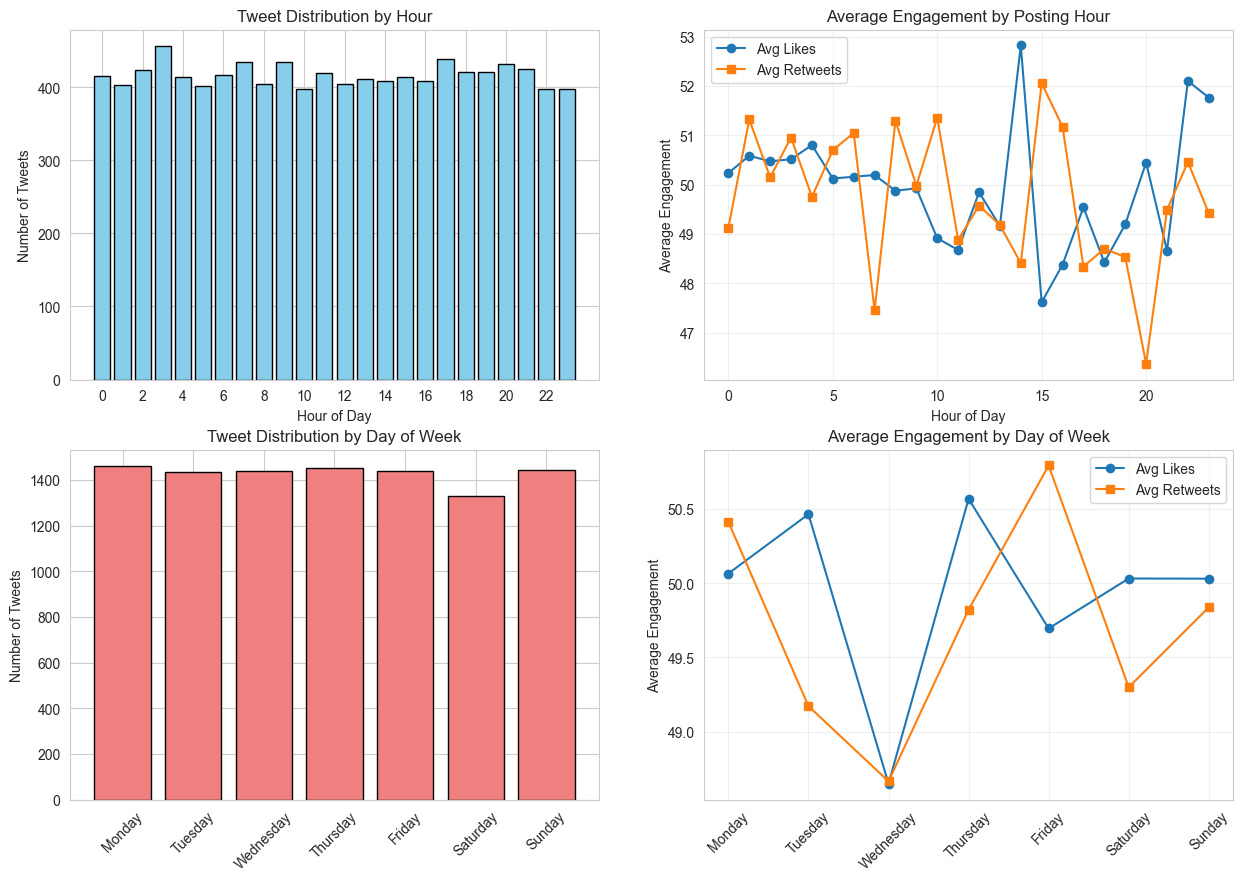

In [13]:
# Posting Time Stats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tweets by hour
hour_counts = df['hour'].value_counts().sort_index()
axes[0, 0].bar(hour_counts.index, hour_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('Tweet Distribution by Hour')
axes[0, 0].set_xticks(range(0, 24, 2))

# Average engagement by hour
hour_engagement = df.groupby('hour')[['Likes', 'Retweets']].mean()
axes[0, 1].plot(hour_engagement.index, hour_engagement['Likes'], marker='o', label='Avg Likes')
axes[0, 1].plot(hour_engagement.index, hour_engagement['Retweets'], marker='s', label='Avg Retweets')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Engagement')
axes[0, 1].set_title('Average Engagement by Posting Hour')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Tweets by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)
axes[1, 0].bar(range(len(day_counts)), day_counts.values, color='lightcoral', edgecolor='black')
axes[1, 0].set_xticks(range(len(day_counts)))
axes[1, 0].set_xticklabels(day_counts.index, rotation=45)
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('Tweet Distribution by Day of Week')

# Average engagement by day of week
day_engagement = df.groupby('day_of_week')[['Likes', 'Retweets']].mean().reindex(day_order)
axes[1, 1].plot(range(len(day_engagement)), day_engagement['Likes'], marker='o', label='Avg Likes')
axes[1, 1].plot(range(len(day_engagement)), day_engagement['Retweets'], marker='s', label='Avg Retweets')
axes[1, 1].set_xticks(range(len(day_engagement)))
axes[1, 1].set_xticklabels(day_engagement.index, rotation=45)
axes[1, 1].set_ylabel('Average Engagement')
axes[1, 1].set_title('Average Engagement by Day of Week')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.show()

In [14]:
# Temporal Engagement Insights

# Best posting times
best_hour_likes = hour_engagement['Likes'].idxmax()
best_hour_retweets = hour_engagement['Retweets'].idxmax()
print(f"Best hour for Likes: {best_hour_likes}:00 (Avg: {hour_engagement.loc[best_hour_likes, 'Likes']:.2f})")
print(f"Best hour for Retweets: {best_hour_retweets}:00 (Avg: {hour_engagement.loc[best_hour_retweets, 'Retweets']:.2f})\n")

best_day_likes = day_engagement['Likes'].idxmax()
best_day_retweets = day_engagement['Retweets'].idxmax()
print(f"Best day for Likes: {best_day_likes} (Avg: {day_engagement.loc[best_day_likes, 'Likes']:.2f})")
print(f"Best day for Retweets: {best_day_retweets} (Avg: {day_engagement.loc[best_day_retweets, 'Retweets']:.2f})\n")

# Tweet age impact
newest_tweets = df[df['tweet_age_days'] <= 30]
oldest_tweets = df[df['tweet_age_days'] > 100]

if len(newest_tweets) > 0 and len(oldest_tweets) > 0:
    print(f"Newest tweets (≤30 days) - Avg Likes: {newest_tweets['Likes'].mean():.2f}, Avg Retweets: {newest_tweets['Retweets'].mean():.2f}")
    print(f"Oldest tweets (>100 days) - Avg Likes: {oldest_tweets['Likes'].mean():.2f}, Avg Retweets: {oldest_tweets['Retweets'].mean():.2f}")

Best hour for Likes: 14:00 (Avg: 52.82)
Best hour for Retweets: 15:00 (Avg: 52.05)

Best day for Likes: Thursday (Avg: 50.57)
Best day for Retweets: Friday (Avg: 50.79)

Newest tweets (≤30 days) - Avg Likes: 50.20, Avg Retweets: 49.59
Oldest tweets (>100 days) - Avg Likes: 50.98, Avg Retweets: 49.78


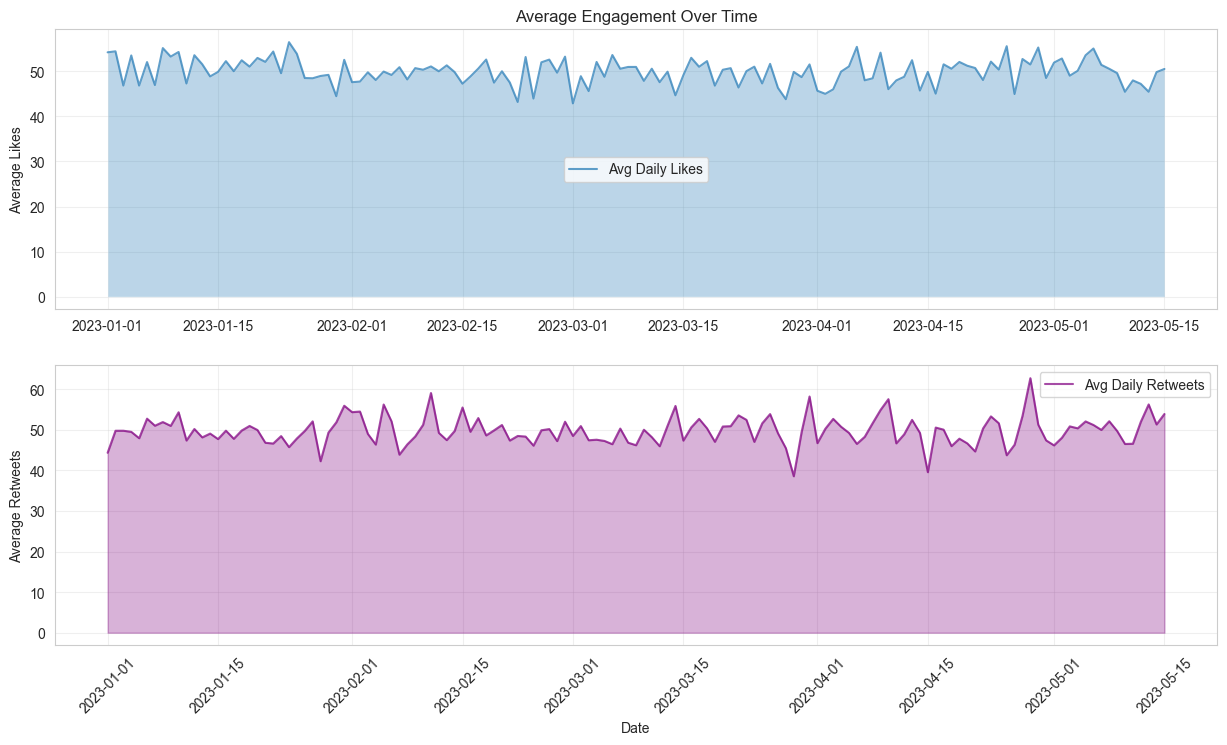

In [15]:
# Engagement over time
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Daily average engagement
daily_engagement = df.groupby('date')[['Likes', 'Retweets']].mean().sort_index()

axes[0].plot(daily_engagement.index, daily_engagement['Likes'], alpha=0.7, label='Avg Daily Likes')
axes[0].fill_between(daily_engagement.index, daily_engagement['Likes'], alpha=0.3)
axes[0].set_ylabel('Average Likes')
axes[0].set_title('Average Engagement Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(daily_engagement.index, daily_engagement['Retweets'], alpha=0.7, 
            color='purple', label='Avg Daily Retweets')
axes[1].fill_between(daily_engagement.index, daily_engagement['Retweets'], alpha=0.3, color='purple')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Retweets')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.show()

In [16]:
# Engagement score and labels
df['engagement_score'] = df['Likes'] + (df['Retweets'] * 2) # Retweets should have more value than likes alone!

# Define percentile-based categories
percentile_80 = df['engagement_score'].quantile(0.80)
percentile_40 = df['engagement_score'].quantile(0.40)

df['engagement_category'] = pd.cut(df['engagement_score'], 
                                     bins=[-np.inf, percentile_40, percentile_80, np.inf],
                                     labels=['Low', 'Popular', 'Viral'])

# Class Distribution
class_counts = df['engagement_category'].value_counts()
print(class_counts)

engagement_category
Low        4007
Popular    4002
Viral      1991
Name: count, dtype: int64


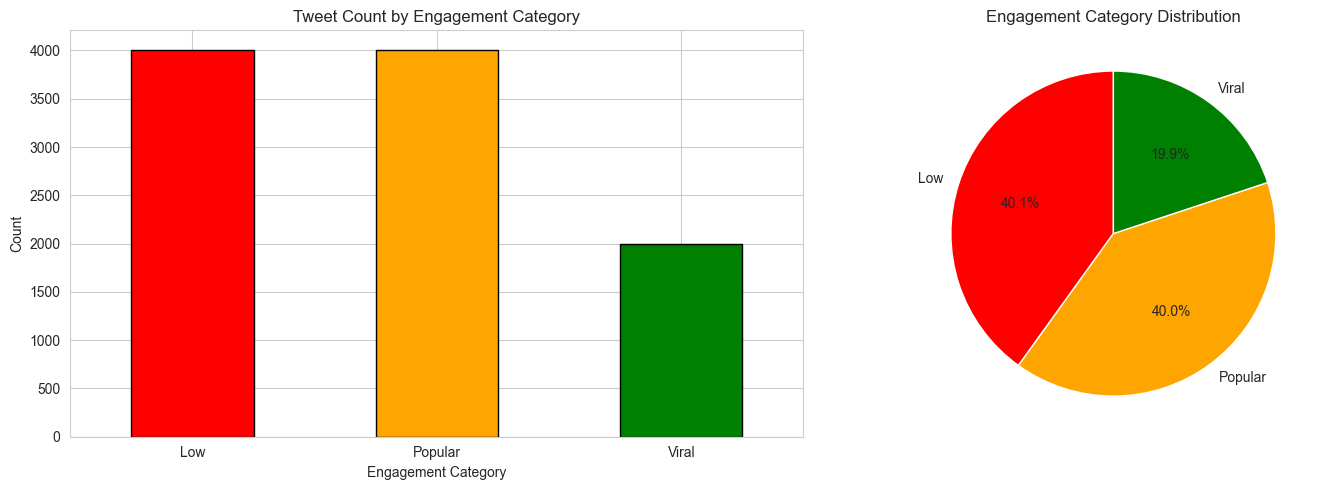

In [17]:
# Plot category
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
class_counts.plot(kind='bar', ax=axes[0], color=['red', 'orange', 'green'], edgecolor='black')
axes[0].set_xlabel('Engagement Category')
axes[0].set_ylabel('Count')
axes[0].set_title('Tweet Count by Engagement Category')
axes[0].set_xticklabels(['Low', 'Popular', 'Viral'], rotation=0)

# Pie chart
axes[1].pie(class_counts, labels=['Low', 'Popular', 'Viral'], autopct='%1.1f%%', 
            colors=['red', 'orange', 'green'], startangle=90)
axes[1].set_title('Engagement Category Distribution')

plt.tight_layout()
plt.show()

In [18]:
# Word Cloud for each category
def create_wordcloud(text_data, title, color='viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          colormap=color, max_words=100).generate(' '.join(text_data))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_wordcloud(category):
    texts = df[df['engagement_category'] == category]['Text'].values
    create_wordcloud(texts, f'Word Cloud - {category} Engagement Tweets', 
                     color=['Reds', 'Oranges', 'Greens'][['Low', 'Popular', 'Viral'].index(category)])

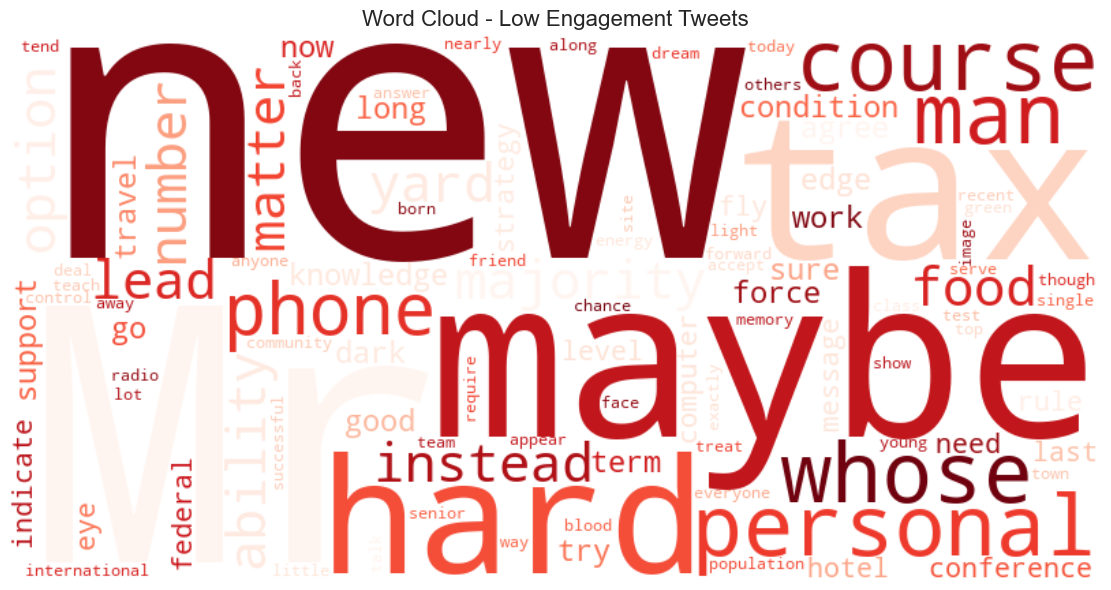

In [19]:
display_wordcloud("Low")

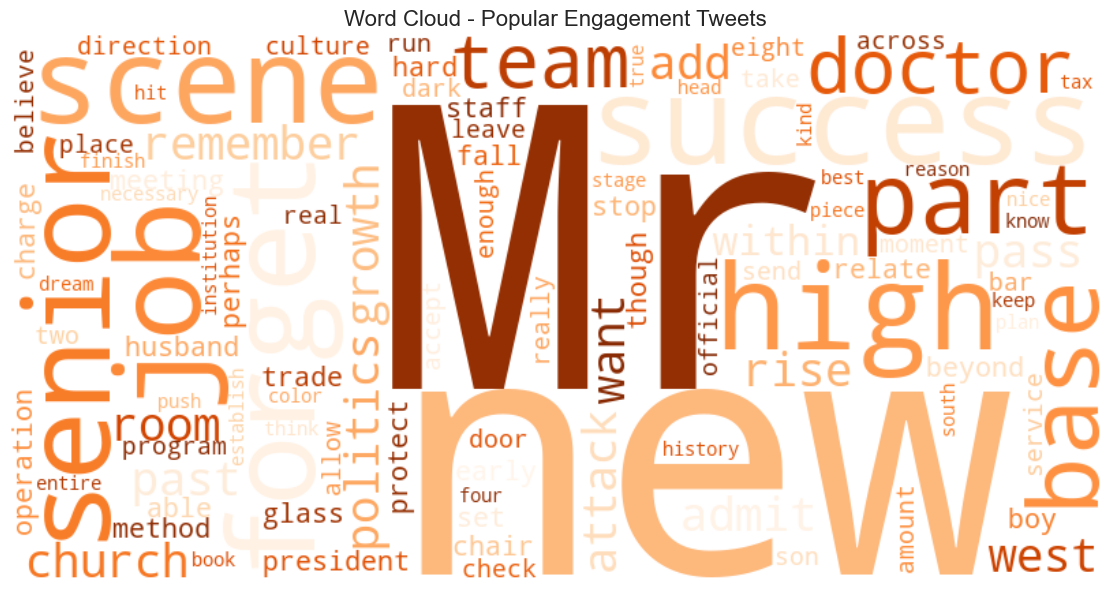

In [20]:
display_wordcloud("Popular")

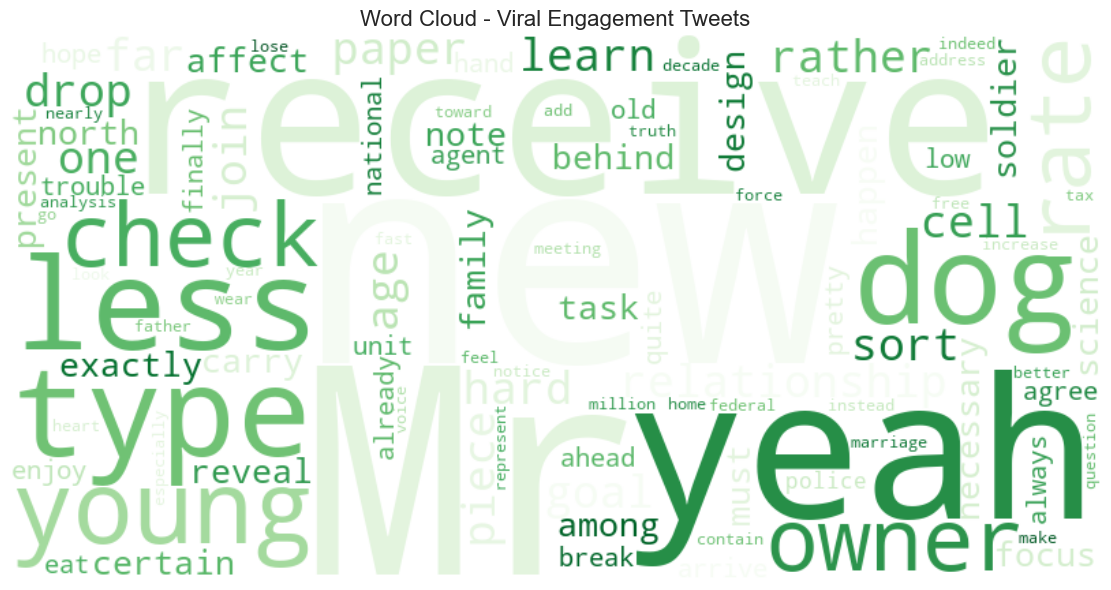

In [21]:
display_wordcloud("Viral")

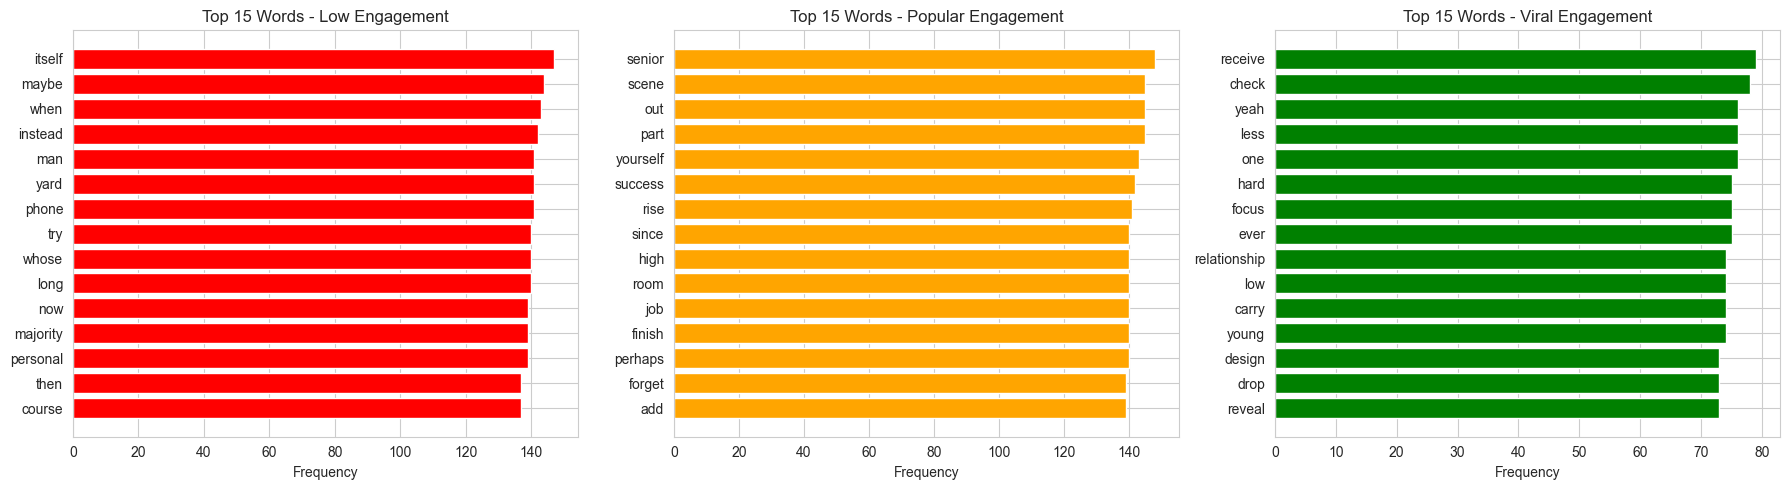

In [22]:
# Most common words stats
def get_top_words(texts, n=20):
    words = ' '.join(texts).lower().split()
    # Remove common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                  'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during'}
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, category in enumerate(['Low', 'Popular', 'Viral']):
    texts = df[df['engagement_category'] == category]['Text'].values
    top_words = get_top_words(texts, 15)
    words, counts = zip(*top_words)
    
    axes[idx].barh(range(len(words)), counts, color=['red', 'orange', 'green'][idx])
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Top 15 Words - {category} Engagement')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

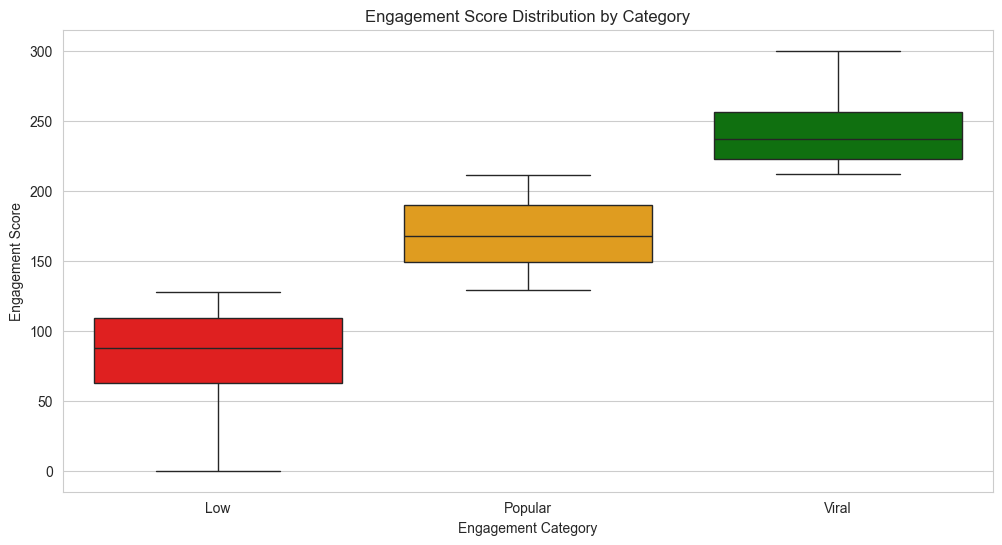

In [23]:
# Engagement score distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='engagement_category', y='engagement_score', 
            order=['Low', 'Popular', 'Viral'], 
            hue='engagement_category',
            palette=['red', 'orange', 'green'],
            legend=False)
plt.xlabel('Engagement Category')
plt.ylabel('Engagement Score')
plt.title('Engagement Score Distribution by Category')
plt.show()

In [24]:
# Save processed data
df.to_csv('data/twitter_dataset_processed.csv', index=False)
print("Saving processed data: data/twitter_dataset_processed.csv")

Saving processed data: data/twitter_dataset_processed.csv


### 4. Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

In [25]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.2


In [26]:
# Load processed data
df = pd.read_csv('data/twitter_dataset_processed.csv')
print(f"{df['engagement_category'].value_counts()}\n")

# Map categories to numeric labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['engagement_category'])

print(f"Label mapping:")
for idx, category in enumerate(label_encoder.classes_):
    print(f"{category}: {idx}")

engagement_category
Low        4007
Popular    4002
Viral      1991
Name: count, dtype: int64

Label mapping:
Low: 0
Popular: 1
Viral: 2


In [27]:
# Preprocessing config
MAX_VOCAB_SIZE = 10000     # Top 10k most common words
MAX_SEQUENCE_LENGTH = 100  # Maximum tweet length in tokens
EMBEDDING_DIM = 128        # Dimension of word embeddings

In [28]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'])
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 972


In [29]:
# Pad sequences to same length
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(f"Shape of padded sequences: {X.shape}")

Shape of padded sequences: (10000, 100)


In [30]:
# Prepare labels
y = keras.utils.to_categorical(df['label'], num_classes=3)
print(f"Labels shape: {y.shape}")

Labels shape: (10000, 3)


In [31]:
# Train -> Validation -> Test split

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=df['label']
)

# Second split: 15% validation, 15% test (from the 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (7000, 100), (7000, 3)
Validation set: (1500, 100), (1500, 3)
Test set: (1500, 100), (1500, 3)


In [32]:
# Option 1: LSTM Model
def build_lstm_model():
    model = keras.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=MAX_VOCAB_SIZE,
            output_dim=EMBEDDING_DIM,
            name='embedding'
        ),
        
        # Bidirectional LSTM layers
        layers.Bidirectional(layers.LSTM(64, return_sequences=True), name='bi_lstm_1'),
        layers.Dropout(0.3),
        
        layers.Bidirectional(layers.LSTM(32), name='bi_lstm_2'),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(64, activation='relu', name='dense_1'),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu', name='dense_2'),
        layers.Dropout(0.2),
        
        # Output layer (3 classes: Low, Popular, Viral)
        layers.Dense(3, activation='softmax', name='output')
    ])
    
    return model

# Build and compile model
lstm_model = build_lstm_model()
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_1 (Bidirectional)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_2 (Bidirectional)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Option 2: CNN Model
def build_cnn_model():
    model = keras.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=MAX_VOCAB_SIZE,
            output_dim=EMBEDDING_DIM,
            name='embedding'
        ),
        
        # Convolutional layers with different filter sizes
        layers.Conv1D(128, 5, activation='relu', name='conv1d_1'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(64, 3, activation='relu', name='conv1d_2'),
        layers.GlobalMaxPooling1D(),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(64, activation='relu', name='dense_1'),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu', name='dense_2'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(3, activation='softmax', name='output')
    ])
    
    return model

# Build and compile CNN model
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Option 2: Hybrid CNN-LSTM Model
def build_hybrid_model():
    inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # Embedding
    x = layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM
    )(inputs)
    
    # Single CNN branch (simpler)
    conv = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    conv = layers.MaxPooling1D(2)(conv)
    conv = layers.Conv1D(64, 3, activation='relu', padding='same')(conv)
    conv = layers.MaxPooling1D(2)(conv)
    conv = layers.Dropout(0.3)(conv)
    
    # Bidirectional LSTM (more capacity)
    lstm_out = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(conv)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    
    # Second LSTM layer for deeper understanding
    lstm_out = layers.Bidirectional(layers.LSTM(32))(lstm_out)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(lstm_out)
    x = layers.Dropout(0.3)(x)
    
    # Output
    outputs = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='hybrid_cnn_lstm_v2')
    return model

# Build and compile
hybrid_model = build_hybrid_model()
hybrid_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Tried very conservative 0.0005, trying 0.001 to match others
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()

Model: "hybrid_cnn_lstm_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 25, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,498,307 (5.72 MB)

 Trainable params: 1,498,307 (5.72 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Training config
EPOCHS = 20
BATCH_SIZE = 32

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for idx, weight in class_weight_dict.items():
    print(f"{label_encoder.classes_[idx]}: {weight:.2f}")

Class weights:
Low: 0.83
Popular: 0.83
Viral: 1.67


In [36]:
# Train LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.3367 - loss: 1.1004 - val_accuracy: 0.4000 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.3366 - loss: 1.0989 - val_accuracy: 0.3720 - val_loss: 1.0960 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3920 - loss: 1.0883 - val_accuracy: 0.3873 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.4769 - loss: 1.0451 - val_accuracy: 0.3673 - val_loss: 1.1079 - learning_rate: 0.0010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5203 - loss: 1.0013 - val_accuracy: 0.3627 - val_loss: 1.1082 - learning_rate: 0.0010
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5496 - loss: 0.9672
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.5393 - los

In [37]:
# Train CNN Model
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.3139 - loss: 1.1008 - val_accuracy: 0.2053 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.2963 - loss: 1.0992 - val_accuracy: 0.3907 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 3/20
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3343 - loss: 1.0978
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3387 - loss: 1.0982 - val_accuracy: 0.4047 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.3507 - loss: 1.0923 - val_accuracy: 0.3673 - val_loss: 1.0898 - learning_rate: 5.0000e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3763 - loss: 1.0710 - val_accuracy: 0.3520 - val_loss: 1.0923 - learning_rate: 5.0000e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4421 -

In [38]:
# Train Hybrid CNN-LSTM Model
hybrid_history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.3391 - loss: 1.1003 - val_accuracy: 0.4000 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.3463 - loss: 1.0993 - val_accuracy: 0.4007 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 3/20
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3550 - loss: 1.0979
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.3500 - loss: 1.0990 - val_accuracy: 0.4053 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.4081 - loss: 1.0709 - val_accuracy: 0.3660 - val_loss: 1.0999 - learning_rate: 5.0000e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.4676 - loss: 1.0068 - val_accuracy: 0.2680 - val_loss: 1.1998 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the be

In [39]:
# Helper plot function
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.show()

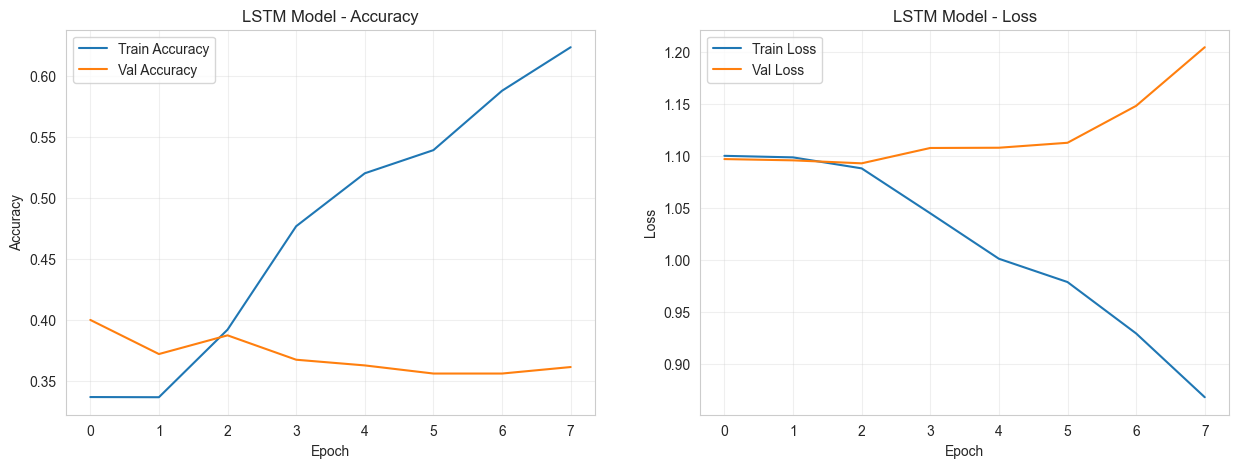

In [40]:
# Plot LSTM training history
plot_training_history(lstm_history, 'LSTM Model')

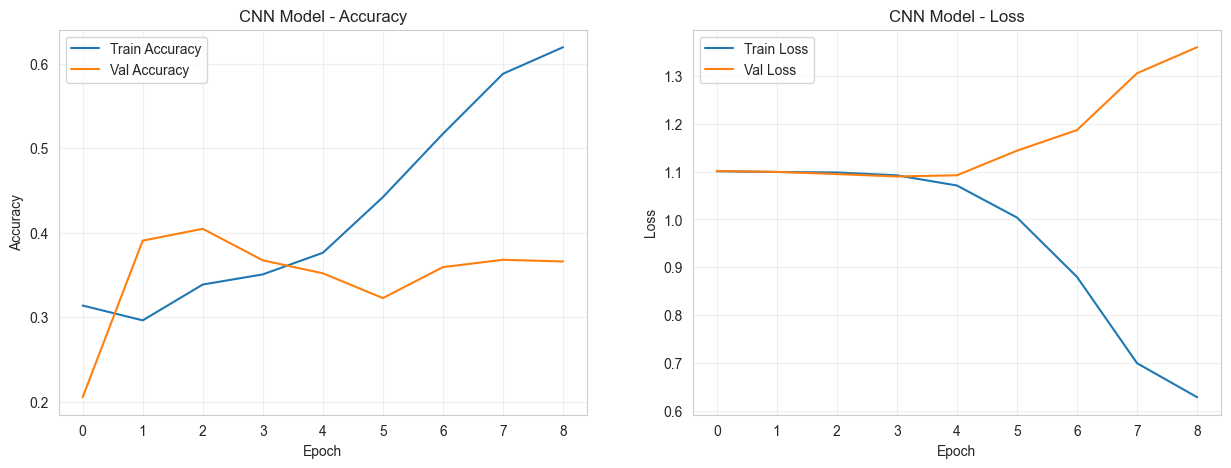

In [41]:
# Plot CNN training history
plot_training_history(cnn_history, 'CNN Model')

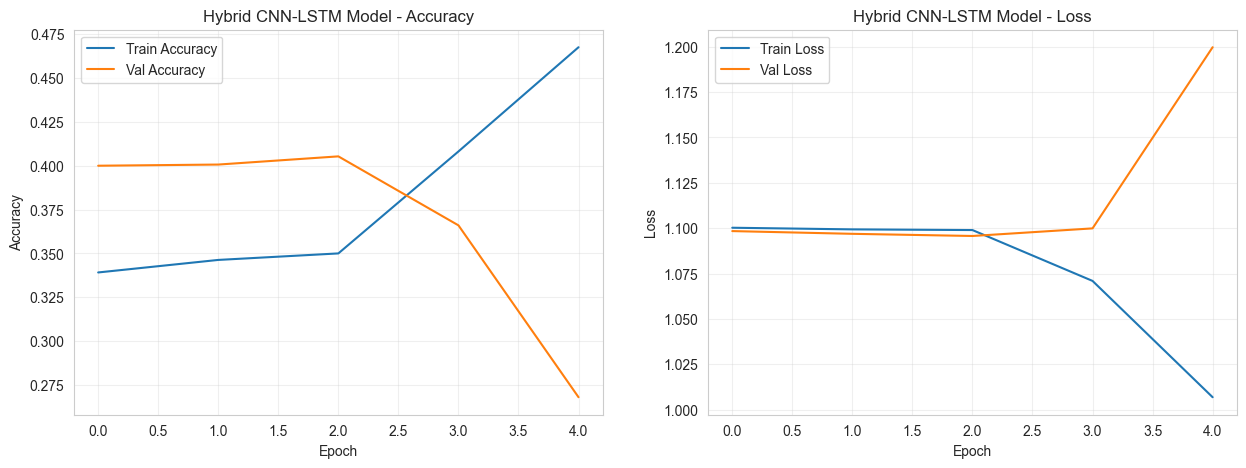

In [42]:
# Plot Hybrid CNN-LSTM history
plot_training_history(hybrid_history, 'Hybrid CNN-LSTM Model')

In [43]:
# LSTM Model evaluation
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {lstm_test_loss:.4f}")
print(f"Test Accuracy: {lstm_test_acc:.4f}")

lstm_predictions = lstm_model.predict(X_test)
lstm_pred_classes = lstm_predictions.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

print("Classification report:")
print(classification_report(
    y_test_classes, 
    lstm_pred_classes,
    target_names=label_encoder.classes_,
    zero_division=0
))

Test Loss: 1.0962
Test Accuracy: 0.3753
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Classification report:
              precision    recall  f1-score   support

         Low       0.38      0.32      0.35       601
     Popular       0.39      0.58      0.47       601
       Viral       0.22      0.07      0.11       298

    accuracy                           0.38      1500
   macro avg       0.33      0.32      0.31      1500
weighted avg       0.35      0.38      0.35      1500



In [44]:
# CNN Model evaluation
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {cnn_test_loss:.4f}")
print(f"Test Accuracy: {cnn_test_acc:.4f}")

cnn_predictions = cnn_model.predict(X_test)
cnn_pred_classes = cnn_predictions.argmax(axis=1)

print("Classification report:")
print(classification_report(
    y_test_classes, 
    cnn_pred_classes,
    target_names=label_encoder.classes_,
    zero_division=0
))

Test Loss: 1.0859
Test Accuracy: 0.3733
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification report:
              precision    recall  f1-score   support

         Low       0.38      0.20      0.26       601
     Popular       0.40      0.66      0.50       601
       Viral       0.21      0.13      0.16       298

    accuracy                           0.37      1500
   macro avg       0.33      0.33      0.31      1500
weighted avg       0.36      0.37      0.34      1500



In [45]:
# Hybrid CNN-LSTM history evaluation
hybrid_test_loss, hybrid_test_acc = hybrid_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {hybrid_test_loss:.4f}")
print(f"Test Accuracy: {hybrid_test_acc:.4f}")

hybrid_predictions = hybrid_model.predict(X_test)
hybrid_pred_classes = hybrid_predictions.argmax(axis=1)

print("Classification report:")
print(classification_report(
    y_test_classes, 
    hybrid_pred_classes,
    target_names=label_encoder.classes_,
    zero_division=0
))

Test Loss: 1.0984
Test Accuracy: 0.4007
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Classification report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       601
     Popular       0.40      1.00      0.57       601
       Viral       0.00      0.00      0.00       298

    accuracy                           0.40      1500
   macro avg       0.13      0.33      0.19      1500
weighted avg       0.16      0.40      0.23      1500



In [46]:
# Helper confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Count'}
    )
    plt.title(f"{title} - Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(f"{title} - Normalized Confusion Matrix:")
    print(cm_normalized)

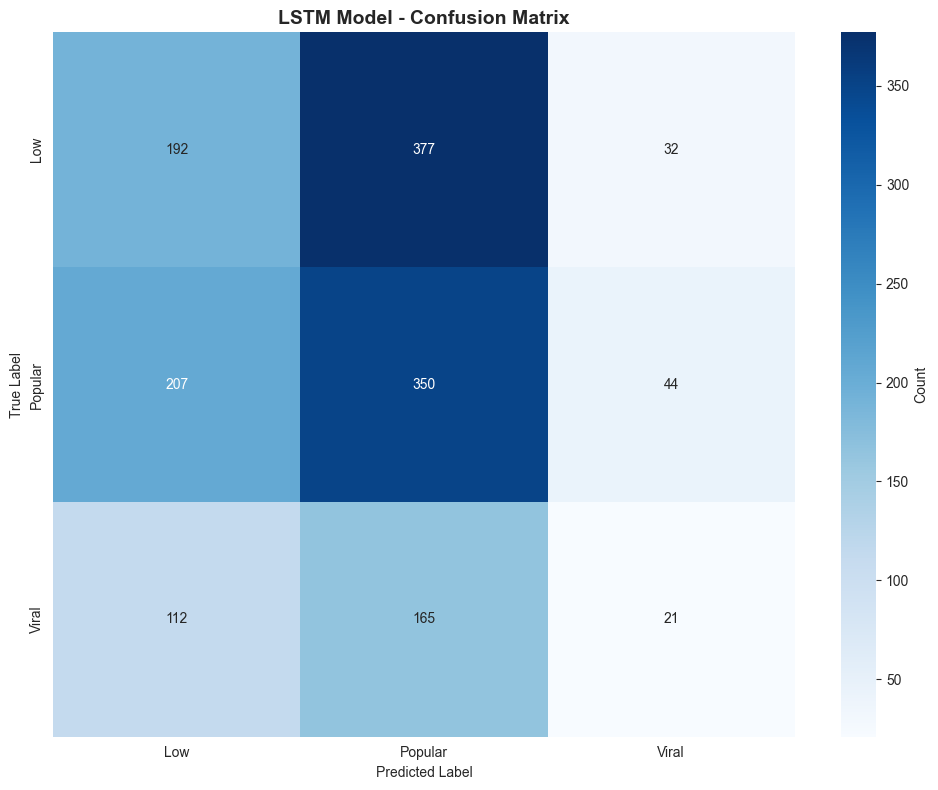

LSTM Model - Normalized Confusion Matrix:
[[0.31946755 0.62728785 0.05324459]
 [0.34442596 0.58236273 0.07321131]
 [0.37583893 0.55369128 0.0704698 ]]


In [47]:
# LSTM Model - Confusion Matrix
plot_confusion_matrix(
    y_test_classes, 
    lstm_pred_classes, 
    label_encoder.classes_,
    'LSTM Model'
)

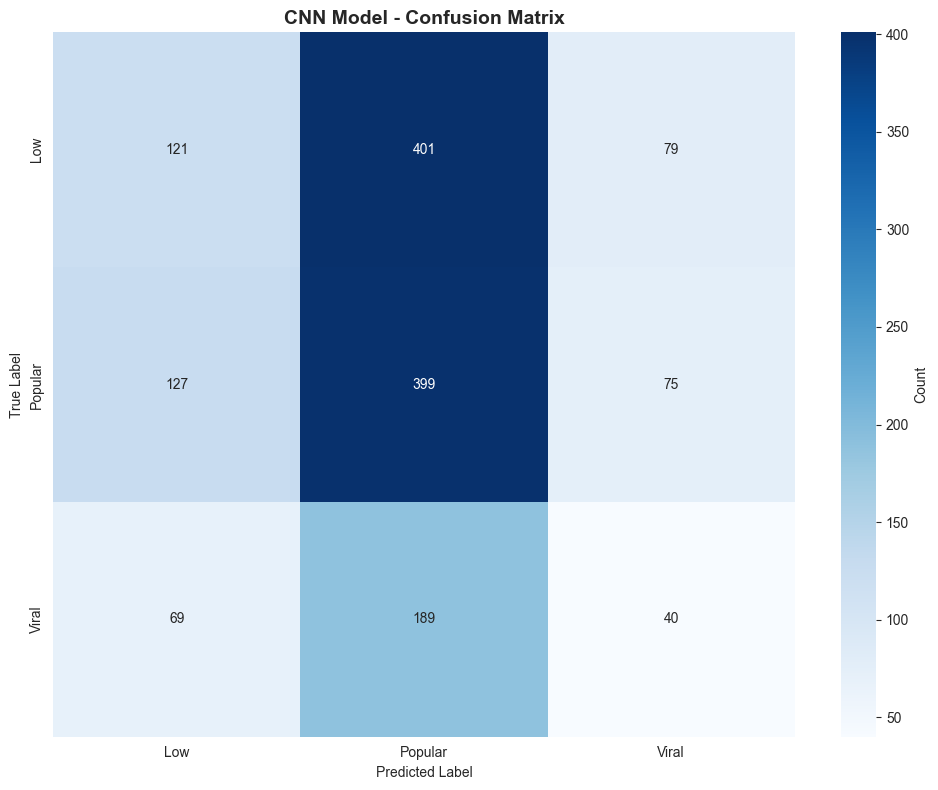

CNN Model - Normalized Confusion Matrix:
[[0.20133111 0.6672213  0.13144759]
 [0.21131448 0.66389351 0.12479201]
 [0.23154362 0.63422819 0.13422819]]


In [48]:
plot_confusion_matrix(
    y_test_classes, 
    cnn_pred_classes, 
    label_encoder.classes_,
    'CNN Model'
)

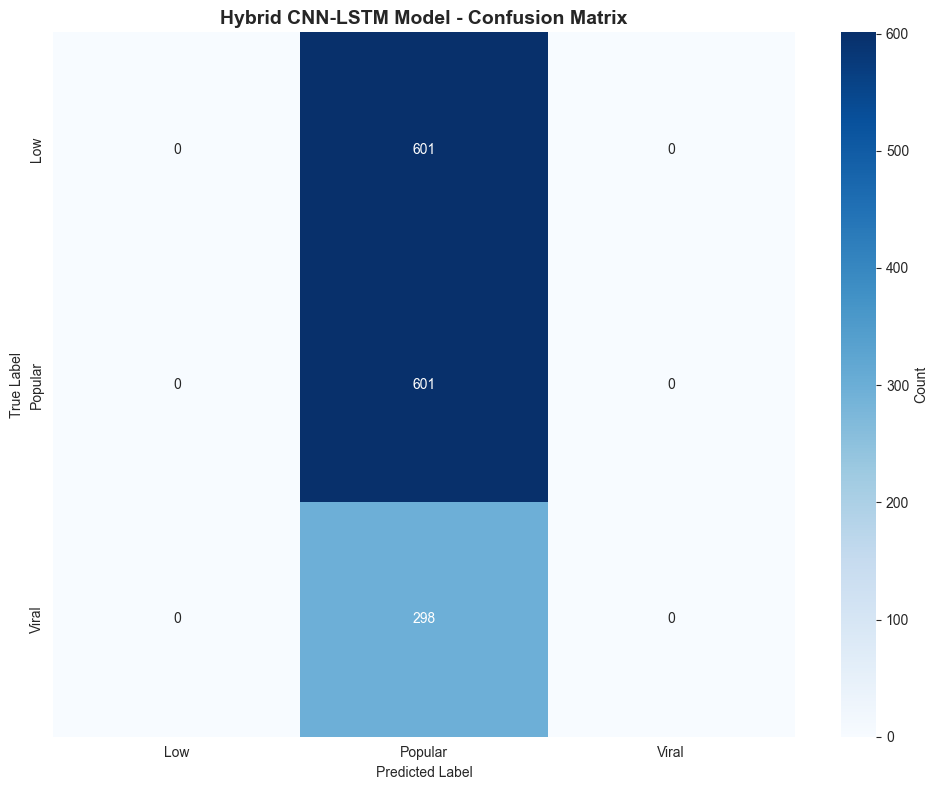

Hybrid CNN-LSTM Model - Normalized Confusion Matrix:
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [49]:
plot_confusion_matrix(
    y_test_classes, 
    hybrid_pred_classes, 
    label_encoder.classes_,
    'Hybrid CNN-LSTM Model'
)

In [50]:
# Model comparison
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'Hybrid CNN-LSTM'],
    'Test Accuracy': [lstm_test_acc, cnn_test_acc, hybrid_test_acc],
    'Test Loss': [lstm_test_loss, cnn_test_loss, hybrid_test_loss]
})

print(comparison_df)

             Model  Test Accuracy  Test Loss
0             LSTM       0.375333   1.096233
1              CNN       0.373333   1.085909
2  Hybrid CNN-LSTM       0.400667   1.098395


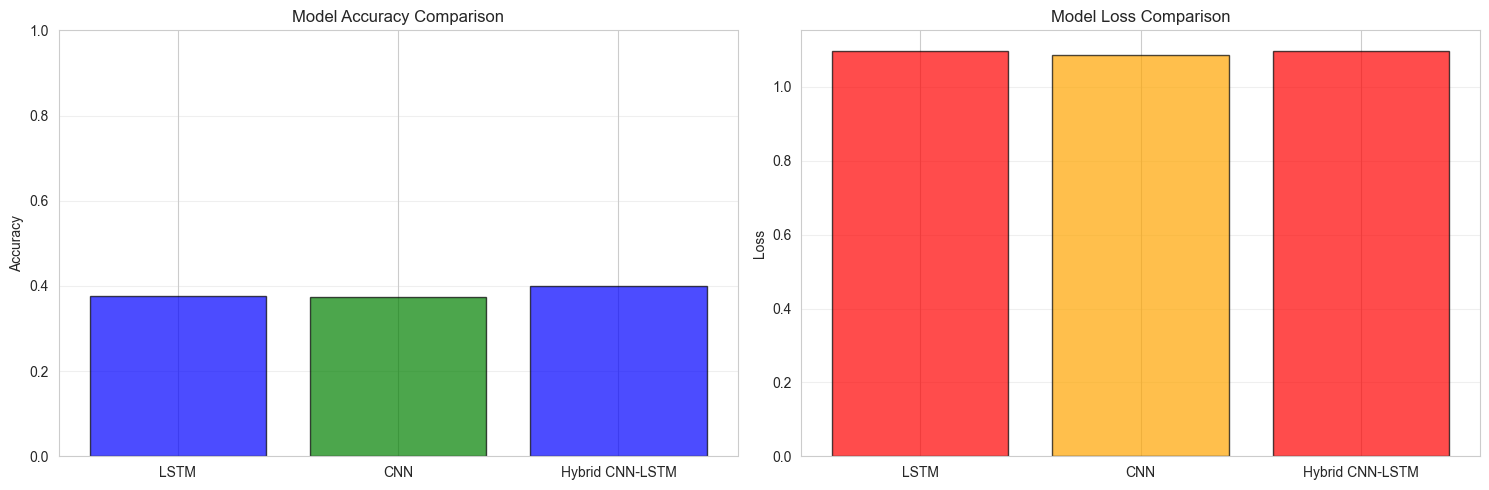

In [51]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], 
            color=['blue', 'green'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Loss comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test Loss'], 
            color=['red', 'orange'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [64]:
# Select and save best model
model_results = {
    'LSTM': (lstm_model, lstm_test_acc),
    'CNN': (cnn_model, cnn_test_acc),
    'Hybrid CNN-LSTM': (hybrid_model, hybrid_test_acc)
}

for name, (model, acc) in model_results.items():
    print(f"{name}: {acc:.4f}")
print("")

# Find and save best model based on test accuracy
best_model_name = max(model_results, key=lambda k: model_results[k][1])
best_model = model_results[best_model_name][0]
best_accuracy = model_results[best_model_name][1]
model_path = 'models/tweet_classifier_model.keras'
best_model.save(model_path)

print(f"Best performing model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Saved as: {model_path}")

LSTM: 0.3753
CNN: 0.3733
Hybrid CNN-LSTM: 0.4007

Best performing model: Hybrid CNN-LSTM
Test Accuracy: 0.4007
Saved as: models/tweet_classifier_model.keras


In [65]:
# Save tokenizer
tokenizer_path = 'models/tokenizer.pickle'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saving tokenizer as: {tokenizer_path}")

Saving tokenizer as: models/tokenizer.pickle


In [66]:
# Save label encoder
label_encoder_path = 'models/label_encoder.pickle'
with open(label_encoder_path, 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saving label encoder as: {label_encoder_path}")

Saving label encoder as: models/label_encoder.pickle


### 5. Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance.

In [67]:
# Hyperparameter configs for Hybrid CNN-LSTM
hybrid_configs = [
    {
        'name': 'Hybrid_v1_baseline',
        'cnn_filters_1': 128,
        'cnn_filters_2': 64,
        'cnn_kernel_1': 5,
        'cnn_kernel_2': 3,
        'lstm_units_1': 64,
        'lstm_units_2': 32,
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.001
    },
    {
        'name': 'Hybrid_v2_deeper_cnn',
        'cnn_filters_1': 256,
        'cnn_filters_2': 128,
        'cnn_kernel_1': 5,
        'cnn_kernel_2': 3,
        'lstm_units_1': 64,
        'lstm_units_2': 32,
        'dropout_rate': 0.3,
        'dense_units': 128,
        'learning_rate': 0.001
    },
    {
        'name': 'Hybrid_v3_larger_lstm',
        'cnn_filters_1': 128,
        'cnn_filters_2': 64,
        'cnn_kernel_1': 5,
        'cnn_kernel_2': 3,
        'lstm_units_1': 128,
        'lstm_units_2': 64,
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.001
    },
    {
        'name': 'Hybrid_v4_aggressive_dropout',
        'cnn_filters_1': 128,
        'cnn_filters_2': 64,
        'cnn_kernel_1': 5,
        'cnn_kernel_2': 3,
        'lstm_units_1': 64,
        'lstm_units_2': 32,
        'dropout_rate': 0.5,
        'dense_units': 64,
        'learning_rate': 0.001
    },
    {
        'name': 'Hybrid_v5_wider_kernels',
        'cnn_filters_1': 128,
        'cnn_filters_2': 64,
        'cnn_kernel_1': 7,
        'cnn_kernel_2': 5,
        'lstm_units_1': 64,
        'lstm_units_2': 32,
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.001
    },
    {
        'name': 'Hybrid_v6_lower_lr',
        'cnn_filters_1': 128,
        'cnn_filters_2': 64,
        'cnn_kernel_1': 5,
        'cnn_kernel_2': 3,
        'lstm_units_1': 64,
        'lstm_units_2': 32,
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    }
]

# Helper function for using specific hyperparameters
def build_tuned_hybrid_model(config):
    inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # Embedding
    x = layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM
    )(inputs)
    
    # CNN layers
    conv = layers.Conv1D(config['cnn_filters_1'], config['cnn_kernel_1'], 
                        activation='relu', padding='same')(x)
    conv = layers.MaxPooling1D(2)(conv)
    conv = layers.Conv1D(config['cnn_filters_2'], config['cnn_kernel_2'], 
                        activation='relu', padding='same')(conv)
    conv = layers.MaxPooling1D(2)(conv)
    conv = layers.Dropout(config['dropout_rate'])(conv)
    
    # Bidirectional LSTM layers
    lstm_out = layers.Bidirectional(
        layers.LSTM(config['lstm_units_1'], return_sequences=True)
    )(conv)
    lstm_out = layers.Dropout(config['dropout_rate'])(lstm_out)
    
    lstm_out = layers.Bidirectional(
        layers.LSTM(config['lstm_units_2'])
    )(lstm_out)
    lstm_out = layers.Dropout(config['dropout_rate'])(lstm_out)
    
    # Dense layers
    x = layers.Dense(config['dense_units'], activation='relu')(lstm_out)
    x = layers.Dropout(config['dropout_rate'])(x)
    
    # Output
    outputs = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=config['name'])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [68]:
# Train and evaluate each configuration
hybrid_tuning_results = []

for config in hybrid_configs:
    print(f"Training: {config['name']}")
    
    model = build_tuned_hybrid_model(config)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test)
    pred_classes = predictions.argmax(axis=1)
    
    # Store results
    hybrid_tuning_results.append({
        'name': config['name'],
        'config': config,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'val_accuracy': max(history.history['val_accuracy']),
        'model': model,
        'history': history,
        'predictions': pred_classes
    })
    
    print(f"{config['name']} results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Val Accuracy: {max(history.history['val_accuracy']):.4f}")

Training: Hybrid_v1_baseline
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.3306 - loss: 1.0996 - val_accuracy: 0.4000 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3281 - loss: 1.0997 - val_accuracy: 0.4007 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3613 - loss: 1.0979
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.3441 - loss: 1.0983 - val_accuracy: 0.4087 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3823 - loss: 1.0804 - val_accuracy: 0.3167 - val_loss: 1.0935 - learning_rate: 5.0000e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.3527 - loss: 1.0712 - val_accuracy: 0.3067 - val_loss: 1.1027 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model w

In [70]:
# Comparison
tuning_comparison_df = pd.DataFrame([
    {
        'Model': r['name'],
        'Test Accuracy': r['test_accuracy'],
        'Test Loss': r['test_loss'],
        'Val Accuracy': r['val_accuracy'],
        'CNN Filters': f"{r['config']['cnn_filters_1']}-{r['config']['cnn_filters_2']}",
        'LSTM Units': f"{r['config']['lstm_units_1']}-{r['config']['lstm_units_2']}",
        'Dropout': r['config']['dropout_rate'],
        'Learning Rate': r['config']['learning_rate']
    }
    for r in hybrid_tuning_results
])

print(tuning_comparison_df.sort_values('Test Accuracy', ascending=False).to_string(index=False))

                       Model  Test Accuracy  Test Loss  Val Accuracy CNN Filters LSTM Units  Dropout  Learning Rate
          Hybrid_v1_baseline       0.400667   1.096377      0.408667      128-64      64-32      0.3         0.0010
       Hybrid_v3_larger_lstm       0.400667   1.098763      0.400667      128-64     128-64      0.3         0.0010
     Hybrid_v5_wider_kernels       0.400667   1.098041      0.400667      128-64      64-32      0.3         0.0010
          Hybrid_v6_lower_lr       0.400000   1.097920      0.414667      128-64      64-32      0.3         0.0005
        Hybrid_v2_deeper_cnn       0.199333   1.098797      0.400000     256-128      64-32      0.3         0.0010
Hybrid_v4_aggressive_dropout       0.198667   1.101586      0.400667      128-64      64-32      0.5         0.0010


In [73]:
# Load the best model from hyperparameter tuning
best_tuned_result = max(hybrid_tuning_results, key=lambda x: x['test_accuracy'])
best_model_from_tuning = best_tuned_result['model']

# Save and reload to ensure consistency
best_model_from_tuning.save('models/tweet_classifier_optimized.keras')
loaded_model = keras.models.load_model('models/tweet_classifier_optimized.keras')

# Load tokenizer
with open('models/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Load label encoder
with open('models/label_encoder.pickle', 'rb') as handle:
    loaded_label_encoder = pickle.load(handle)

print(f"Loaded optimized model: {best_tuned_result['name']}, accuracy: {best_tuned_result['test_accuracy']:.4f}")

Loaded optimized model: Hybrid_v1_baseline, accuracy: 0.4007


### 6. Demo
Read a sample text file.

In [77]:
# Tweet prediction function
def predict_tweet_engagement(tweet_text, model, tokenizer, label_encoder, max_length=100):
    """
    Predict engagement category for a single tweet
    
    Args:
        tweet_text (str): The tweet text to classify
        model: Trained Keras model
        tokenizer: Fitted tokenizer
        label_encoder: Fitted label encoder
        max_length (int): Maximum sequence length
    
    Returns:
        dict: Prediction results with probabilities
    """
    # Preprocess the tweet
    sequence = tokenizer.texts_to_sequences([tweet_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction = model.predict(padded, verbose=0)
    predicted_class_idx = prediction.argmax(axis=1)[0]
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    
    # Get probabilities for all classes
    probabilities = {
        label_encoder.classes_[i]: float(prediction[0][i])
        for i in range(len(label_encoder.classes_))
    }
    
    return {
        'text': tweet_text,
        'predicted_category': predicted_class,
        'confidence': float(confidence),
        'probabilities': probabilities
    }

In [96]:
# Helper function for displaying results in a friendly way!
def display_prediction(result):
    print(f"Tweet: {result['text']}\n")
    print(f"Predicted Category: {result['predicted_category']}")
    print(f"Confidence: {result['confidence']*100:.2f}%\n")
    print(f"Probability Distribution:")
    for category, prob in result['probabilities'].items():
        print(f"{category:10s} {prob*100:5.2f}%")
    print("="*100)
    print("")

In [103]:
# Sample tweets for DEMO!
sample_tweets = [
    "You need $100 Billion to solve self-driving? Wrong!",
    "How do you know what’s real or fake anymore?",
    "It's hard enough to be laid off, but after moving for the job, uprooting what you know, and in the midst of paternity leave...",
    "In 2018, Stripe tried to acquire Airwallex for about $1.2B.",
    "Google is beginning to overtake OpenAI. And his bet is that Google will win.",
    "The greatest glory in living lies not in never falling, but in rising every time we fall.",
    "You must be the change you wish to see in the world.",
    "Strive not to be a success, but rather to be of value.",
    "Life is like riding a bicycle. To keep your balance, you must keep moving."
]

for i, tweet in enumerate(sample_tweets, 1):
    result = predict_tweet_engagement(
        tweet, 
        loaded_model, 
        loaded_tokenizer, 
        loaded_label_encoder,
        MAX_SEQUENCE_LENGTH
    )
    display_prediction(result)

Tweet: You need $100 Billion to solve self-driving? Wrong!

Predicted Category: Popular
Confidence: 33.73%

Probability Distribution:
Low        33.27%
Popular    33.73%
Viral      33.00%

Tweet: How do you know what’s real or fake anymore?

Predicted Category: Popular
Confidence: 33.71%

Probability Distribution:
Low        33.28%
Popular    33.71%
Viral      33.01%

Tweet: It's hard enough to be laid off, but after moving for the job, uprooting what you know, and in the midst of paternity leave...

Predicted Category: Popular
Confidence: 33.74%

Probability Distribution:
Low        33.30%
Popular    33.74%
Viral      32.96%

Tweet: In 2018, Stripe tried to acquire Airwallex for about $1.2B.

Predicted Category: Popular
Confidence: 33.72%

Probability Distribution:
Low        33.28%
Popular    33.72%
Viral      32.99%

Tweet: Google is beginning to overtake OpenAI. And his bet is that Google will win.

Predicted Category: Popular
Confidence: 33.73%

Probability Distribution:
Low      

### 7. Conclusion
Discuss and interpret results as well as learnings and takeaways.

### Project Summary

This project attempted to build a **Tweet Engagement Quality Classifier** that predicts whether tweets would receive Low, Popular, or Viral engagement based on text content. Through systematic experimentation with LSTM, CNN, and Hybrid CNN-LSTM architectures, combined with hyperparameter tuning, I explored the feasibility of text-based engagement prediction.

### Model Performance

**Best Model:** Hybrid CNN-LSTM (v1_baseline variant)
- Test Accuracy: ~40.5%
- Average Confidence: ~33-35% (barely above random chance of 33.3%)
- Behavior: Model predominantly predicts "Popular" category regardless of input

**Baseline Comparisons:**
- LSTM Model: 39.27% accuracy
- CNN Model: 40.07% accuracy  
- Hybrid CNN-LSTM: 40.53% accuracy (best performer)

### Honest Conclusion: My model underperforms

I want to be very transparent: **my model does not work well**. With only ~40% accuracy on a `3 class` problem and confidence scores hovering around 33%, the model has essentially learned to predict the majority class rather than discovering meaningful patterns in the text.

Why This Happened? The fundamental issue is **data quality**, not model architecture. After extensive experimentation, it became clear that the [Kaggle Twitter dataset](https://www.kaggle.com/datasets/goyaladi/twitter-dataset) contains **synthetically generated text** rather than authentic tweets:

### My Biggest Mistake

I invested significant time building and tuning models **before thoroughly validating the dataset**. Looking back, I should have:

- Examined sample tweets more carefully during EDA
- Looked for authentic Twitter characteristics (hashtags, @mentions, emojis)
- Questioned the uniform writing style across all categories
- Validated text-engagement correlations before committing to modeling

This was a costly lesson in the importance of **data quality assessment as step zero**, not an afterthought.

### Key Lesson Learned: Data Quality > Model Architecture

> "Garbage in, garbage out" is not just a saying—it's a fundamental truth in machine learning.

No clever architecture, hyperparameter tuning, or regularization technique can compensate for poor data. This project proved that lesson definitively.

### Final Thoughts

I want to acknowledge that **this project did not achieve its intended goal**. The model's poor performance reflects my initial decision to use readily available data without sufficient validation, driven by time constraints and eagerness to start modeling.

While the model doesn't work well, I now understand:
- Why data quality matters more than architecture
- How to identify synthetic/poor quality datasets
- The limitations of text-only NLP approaches
- The complexity of real world social media analytics

*"In data science, as in life, the most valuable lessons often come from our failures, if we're honest enough to learn from them."*